In [6]:
import jax, jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pickle
import sys
from Error_System import HRNetworkErrorSystem
from NeuralModel import HindmarshRose, DEFAULT_PARAMS

# JAX configuration to use 64-bit precision.
jax.config.update("jax_enable_x64", True)

# ==============================================================================
# 1. NEURAL NETWORK DEFINITIONS
# ==============================================================================

class FourierFeatures(eqx.Module):
    """Encodes a 1D input into a higher-dimensional space using Fourier features."""
    b_matrix: jax.Array

    def __init__(self, key, in_size=1, mapping_size=32, scale=1):
        self.b_matrix = jax.random.normal(key, (mapping_size // 2, in_size)) * scale

    def __call__(self, t):
        if t.ndim == 1:
            t = t[None, :]
        t_proj = t @ self.b_matrix.T
        return jnp.concatenate([jnp.sin(t_proj), jnp.cos(t_proj)], axis=-1).squeeze()


class StateNN(eqx.Module):
    """An MLP with Fourier Features to approximate the combined state [q(t), s(t)]."""
    layers: list

    def __init__(self, key, out_size=15, width=256, depth=3, mapping_size=32, scale=300):
        fourier_key, *layer_keys = jax.random.split(key, depth + 1)
        self.layers = [
            FourierFeatures(fourier_key, in_size=1, mapping_size=mapping_size, scale=scale),
            eqx.nn.Linear(mapping_size, width, key=layer_keys[0]),
            *[eqx.nn.Linear(width, width, key=key) for i in range(1, depth - 1)],
            eqx.nn.Linear(width, out_size, key=layer_keys[-1])
        ]

    def __call__(self, t):
        x = self.layers[0](t)
        for layer in self.layers[1:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)


# --- sPHNN Component Networks (from sPHNN implementation) ---

class _FICNN(eqx.Module):
    """Internal helper class for a Fully Input Convex Neural Network."""
    w_layers: list
    u_layers: list
    final_layer: eqx.nn.Linear
    activation: callable = eqx.field(static=True)

    def __init__(self, key, in_size: int, out_size: int, width: int, depth: int):
        self.activation = jax.nn.softplus
        keys = jax.random.split(key, depth)
        self.w_layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        self.w_layers.extend([eqx.nn.Linear(in_size, width, key=key) for key in keys[1:-1]])
        self.u_layers = [eqx.nn.Linear(width, width, use_bias=False, key=key) for key in keys[1:-1]]
        self.final_layer = eqx.nn.Linear(width, out_size, use_bias=False, key=keys[-1])

    def __call__(self, s):
        z = self.activation(self.w_layers[0](s))
        for i in range(len(self.u_layers)):
            # Enforce non-negative weights for convexity
            u_layer_non_negative = eqx.tree_at(lambda l: l.weight, self.u_layers[i], jnp.abs(self.u_layers[i].weight))
            z = self.activation(u_layer_non_negative(z) + self.w_layers[i + 1](s))
        return self.final_layer(z)[0]


class HamiltonianNN(eqx.Module):
    """Learns a convex Hamiltonian function H(x) with a guaranteed minimum at x0."""
    ficnn: _FICNN
    x0: jax.Array
    epsilon: float = eqx.field(static=True)

    def __init__(self, key, in_size, width, depth, x0, epsilon):
        self.ficnn = _FICNN(key, in_size, out_size=1, width=width, depth=depth)
        self.x0 = x0
        self.epsilon = epsilon

    def __call__(self, x):
        # Implements Equation (10) from the paper
        f_x = self.ficnn(x)
        f_x0 = self.ficnn(self.x0)
        grad_f_x0 = jax.grad(self.ficnn)(self.x0)
        # Normalization term to set H(x0)=0 and grad H(x0)=0
        f_norm = f_x0 + jnp.dot(grad_f_x0, x - self.x0)
        # Regularization term to ensure a strict minimum
        f_reg = self.epsilon * jnp.sum((x - self.x0) ** 2)
        return f_x - f_norm + f_reg


class DissipationNN(eqx.Module):
    """Learns a positive semi-definite dissipation matrix R(s) = L(s)L(s)^T."""
    layers: list
    activation: callable
    state_dim: int

    def __init__(self, key, state_dim, width, depth, activation):
        self.state_dim = state_dim
        num_l_elements = state_dim * (state_dim + 1) // 2
        keys = jax.random.split(key, depth)
        self.layers = [
            eqx.nn.Linear(state_dim, width, key=keys[0]),
            *[eqx.nn.Linear(width, width, key=key) for key in keys[1:-1]],
            eqx.nn.Linear(width, num_l_elements, key=keys[-1])
        ]
        self.activation = activation

    def __call__(self, s):
        for layer in self.layers[:-1]:
            s = self.activation(layer(s))
        l_elements = self.layers[-1](s)
        
        # Build the lower triangular matrix L
        L = jnp.zeros((self.state_dim, self.state_dim))
        tril_indices = jnp.tril_indices(self.state_dim)
        L = L.at[tril_indices].set(l_elements)
        
        # Enforce positive diagonal elements for positive definiteness
        positive_diag = jax.nn.softplus(jnp.diag(L))
        L = L.at[jnp.diag_indices(self.state_dim)].set(positive_diag)
        
        # Return R = L @ L.T
        return L @ L.T


class DynamicJ_NN(eqx.Module):
    """Learns a skew-symmetric structure matrix J(s)."""
    layers: list
    state_dim: int
    activation: callable

    def __init__(self, key, state_dim, width, depth, activation):
        self.state_dim = state_dim
        num_unique_elements = state_dim * (state_dim - 1) // 2
        keys = jax.random.split(key, depth + 1)
        self.layers = [
            eqx.nn.Linear(state_dim, width, key=keys[0]),
            *[eqx.nn.Linear(width, width, key=key) for key in keys[1:-1]],
            eqx.nn.Linear(width, num_unique_elements, key=keys[-1])
        ]
        self.activation = activation

    def __call__(self, s):
        for layer in self.layers[:-1]:
            s = self.activation(layer(s))
        upper_triangle_elements = self.layers[-1](s)
        
        # Build the matrix from its upper triangular elements
        J = jnp.zeros((self.state_dim, self.state_dim))
        triu_indices = jnp.triu_indices(self.state_dim, k=1)
        J = J.at[triu_indices].set(upper_triangle_elements)
        
        # Enforce skew-symmetry: J = J - J.T
        return J - J.T


# --- The Combined Model ---

class Combined_sPHNN_PINN(eqx.Module):
    """Main model combining a unified state predictor and sPHNN structure."""
    state_net: StateNN
    hamiltonian_net: HamiltonianNN
    dissipation_net: DissipationNN
    j_net: DynamicJ_NN

    def __init__(self, key, config):
        state_key, h_key, d_key, j_key = jax.random.split(key, 4)
        state_dim = config['state_dim']
        # The equilibrium point for the normalized error system is the origin.
        x0_norm = jnp.zeros(state_dim)

        self.state_net = StateNN(key=state_key)
        self.hamiltonian_net = HamiltonianNN(
            h_key, in_size=state_dim, width=config['h_width'], depth=config['h_depth'],
            x0=x0_norm, epsilon=config['h_epsilon']
        )
        self.dissipation_net = DissipationNN(
            d_key, state_dim=state_dim, width=config['d_width'],
            depth=config['d_depth'], activation=config['activation']
        )
        self.j_net = DynamicJ_NN(
            j_key, state_dim=state_dim, width=config['j_width'],
            depth=config['j_depth'], activation=config['activation']
        )


# ==============================================================================
# 2. DATA HANDLING
# ==============================================================================

def generate_data(file_path="data_for_PIN.pkl"):
    """Loads and prepares training data from a pre-generated pickle file."""
    print(f"Loading simulation data from {file_path}...")
    try:
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'data_for_PIN.pkl' is in the same directory.")
        return None, None, None, None, None

    t = jnp.asarray(results['t'])
    s = jnp.vstack([
        results['e_x'], results['e_y'], results['e_z'],
        results['e_u'], results['e_phi']
    ]).T
    q = jnp.vstack([
        results['x1'], results['y1'], results['z1'], results['u1'], results['phi1'],
        results['x2'], results['y2'], results['z2'], results['u2'], results['phi2']
    ]).T
    s_dot_true = jnp.vstack([
        results['d_e_x'], results['d_e_y'], results['d_e_z'],
        results['d_e_u'], results['d_e_phi']
    ]).T
    # Load the analytical Hamiltonian
    H_analytical = jnp.asarray(results['Hamiltonian'])

    print("Data loading complete.")
    return t, s, q, s_dot_true, H_analytical


def normalize(data, mean, std):
    """Normalizes data using pre-computed statistics."""
    return (data - mean) / (std + 1e-8)

def denormalize(data, mean, std):
    """Denormalizes data using pre-computed statistics."""
    return data * std + mean


# ==============================================================================
# 3. TRAINING LOGIC
# ==============================================================================

# --- Helper functions for the new physics-based loss terms ---

def _alpha(u1, u2, m):
    """Helper function for the dissipative field f_d."""
    conds = [
        jnp.logical_and(u1 >= 1, jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(u1 >= 1, u2 <= -1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 >= 1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 <= -1),
        jnp.logical_and(u1 <= -1, u2 >= 1),
        jnp.logical_and(u1 <= -1, jnp.logical_and(u2 > -1, u2 < 1)),
    ]
    choices = [2*m - 1., -1., -1., 2*m - 1., -1., -1., 2*m - 1.]
    return jnp.select(conds, choices, default=-1.)

def _beta(u1, u2, m):
    """Helper function for the dissipative field f_d."""
    conds = [
        jnp.logical_and(u1 >= 1, jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(u1 >= 1, u2 <= -1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 >= 1),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), jnp.logical_and(u2 > -1, u2 < 1)),
        jnp.logical_and(jnp.logical_and(u1 > -1, u1 < 1), u2 <= -1),
        jnp.logical_and(u1 <= -1, u2 >= 1),
        jnp.logical_and(u1 <= -1, jnp.logical_and(u2 > -1, u2 < 1)),
    ]
    choices = [
        2*m * (u1 - 1), -4*m, -2*m * (u1 - 1), 0.,
        -2*m * (u1 + 1), 4*m, 2*m * (u1 + 1),
    ]
    return jnp.select(conds, choices, default=0.)

def f_c_fn(e, q, hr_params):
    """Calculates the conservative vector field f_c(e)."""
    e_x, e_y, e_u, e_phi = e[0], e[1], e[3], e[4]
    x1, u1 = q[0], q[3]
    
    k, f, rho, d, r, s = \
        hr_params['k'], hr_params['f'], hr_params['rho'], hr_params['d'], hr_params['r'], hr_params['s']
    
    return jnp.array([
        e_y + 2*k*f*u1*x1*e_u + rho*x1*e_phi,
        -2*d*x1*e_x,
        r*s*e_x,
        e_x,
        e_x
    ])

def f_d_fn(e, q, hr_params):
    """Calculates the dissipative vector field f_d(e)."""
    e_x, e_y, e_z, e_u, e_phi = e[0], e[1], e[2], e[3], e[4]
    x1, u1, phi1, u2 = q[0], q[3], q[4], q[8]

    a, b, k, h, f, rho, g_e, r, q_param, m = \
        hr_params['a'], hr_params['b'], hr_params['k'], hr_params['h'], \
        hr_params['f'], hr_params['rho'], hr_params['ge'], hr_params['r'], \
        hr_params['q'], hr_params['m']

    N_val = -3*a*x1**2 + 2*b*x1 + k*h + k*f*u1**2 + rho*phi1 - 2*g_e
    alpha_val = _alpha(u1, u2, m)
    beta_val = _beta(u1, u2, m)

    return jnp.array([
        N_val * e_x,
        -e_y,
        -r * e_z,
        alpha_val * e_u + beta_val,
        -q_param * e_phi
    ])

@eqx.filter_jit
def loss_fn(model: Combined_sPHNN_PINN, t_batch_norm, s_true_batch_norm, q_true_batch_norm, s_dot_true_batch_norm, H_true_batch_norm,
            lambda_conservative: float, lambda_dissipative: float, lambda_physics: float, hr_params: dict,
            t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
            stage: int):
    """Calculates the composite loss based on the current training stage."""

    # --- Part 1: State Prediction and Common Calculations ---
    all_states_pred_norm = jax.vmap(model.state_net)(t_batch_norm)
    q_pred_batch_norm = all_states_pred_norm[:, :10]
    s_pred_batch_norm = all_states_pred_norm[:, 10:]

    s_pred = denormalize(s_pred_batch_norm, s_mean, s_std)
    q_pred = denormalize(q_pred_batch_norm, q_mean, q_std)
    s_dot_true_batch = denormalize(s_dot_true_batch_norm, s_dot_mean, s_dot_std)

    # Calculate s_dot from autodiff of the state network
    get_autodiff_grad_s_slice = lambda net, t: jax.jvp(lambda t_scalar: net(t_scalar)[10:], (t,), (jnp.ones_like(t),))[1]
    s_dot_autodiff_norm = jax.vmap(get_autodiff_grad_s_slice, in_axes=(None, 0))(model.state_net, t_batch_norm)
    s_dot_autodiff = s_dot_autodiff_norm * (s_std / (t_std + 1e-8))

    # --- Part 2: Loss Component Calculation ---

    # --- Stage 1 Loss Components ---
    all_states_true_norm = jnp.concatenate([q_true_batch_norm, s_true_batch_norm], axis=1)
    loss_data_unified = jnp.mean((all_states_pred_norm - all_states_true_norm) ** 2)
    loss_s_dot_autodiff = jnp.mean((s_dot_true_batch - s_dot_autodiff) ** 2)
    
    f_c_batch = jax.vmap(f_c_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
    f_d_batch = jax.vmap(f_d_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
    s_dot_diss_cons = f_c_batch + f_d_batch
    loss_s_dot_analytical = jnp.mean((s_dot_diss_cons - s_dot_autodiff) ** 2)

    # --- Stage 2 & 3 Loss Components ---
    grad_H_norm_fn = jax.vmap(jax.grad(model.hamiltonian_net))
    grad_H_norm = grad_H_norm_fn(s_pred_batch_norm)
    grad_H = grad_H_norm / (s_std + 1e-8)

    J_norm = jax.vmap(model.j_net)(s_pred_batch_norm)
    R_norm = jax.vmap(model.dissipation_net)(s_pred_batch_norm)
    s_dot_from_structure_norm = jax.vmap(lambda j, r, g: (j - r) @ g)(J_norm, R_norm, grad_H_norm)
    s_dot_from_structure = s_dot_from_structure_norm * s_std
    loss_phys = jnp.mean((s_dot_true_batch - s_dot_from_structure) ** 2)

    lie_derivative = jax.vmap(jnp.dot)(f_c_batch, grad_H)
    loss_conservative = jnp.mean(lie_derivative ** 2)

    dHdt_from_autodiff = jax.vmap(jnp.dot)(grad_H, s_dot_autodiff)
    dHdt_from_equations = jax.vmap(jnp.dot)(grad_H, f_d_batch)
    loss_dissipative = jnp.mean((dHdt_from_autodiff - dHdt_from_equations) ** 2)
    
    # --- Hamiltonian Loss (for monitoring only) ---
    H_pred_norm = jax.vmap(model.hamiltonian_net)(s_pred_batch_norm)
    H_pred = denormalize(H_pred_norm, H_mean, H_std)
    H_true = denormalize(H_true_batch_norm, H_mean, H_std)
    correlation = jnp.corrcoef(H_true.flatten(), H_pred.flatten())[0, 1]
    sign = jnp.sign(correlation)
    H_pred_aligned = sign * H_pred - jnp.mean(sign * H_pred) + jnp.mean(H_true)
    loss_hamiltonian = jnp.mean((H_pred_aligned - H_true) ** 2)

    # --- Part 3: Select Total Loss Based on Stage ---
    #loss_stage1 = loss_data_unified + loss_s_dot_autodiff + loss_s_dot_analytical
    loss_stage1 = loss_data_unified + loss_s_dot_analytical
    loss_stage2 = ((lambda_conservative * loss_conservative) 
                   + (lambda_dissipative * loss_dissipative) 
                   + (lambda_physics * loss_phys))
    
    if stage == 1:
        total_loss = loss_stage1
    elif stage == 2:
        total_loss = loss_stage2
    else:  # Stage 3
        total_loss = loss_stage1 + loss_stage2

    loss_components = {
        "total": total_loss,
        "data_unified": loss_data_unified,
        "s_dot_autodiff": loss_s_dot_autodiff,
        "s_dot_analytical": loss_s_dot_analytical,
        "phys": loss_phys,
        "conservative": loss_conservative,
        "dissipative": loss_dissipative,
        "hamiltonian": loss_hamiltonian,
    }
    return total_loss, loss_components


@eqx.filter_jit
def train_step(model, opt_state, optimizer, trainable_filter, t_batch_norm, s_batch_norm, q_batch_norm, s_dot_batch_norm, H_batch_norm,
               lambda_conservative, lambda_dissipative, lambda_physics, hr_params, 
               t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std, stage):
    """Performs a single training step on the specified trainable parameters."""
    
    # Define a wrapper for the loss function to pass the trainable filter
    def filtered_loss_fn(filtered_model):
        return loss_fn(
            filtered_model, t_batch_norm, s_batch_norm, q_batch_norm, s_dot_batch_norm, H_batch_norm,
            lambda_conservative, lambda_dissipative, lambda_physics, hr_params, 
            t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
            stage
        )

    # Calculate gradients only for the trainable parts of the model
    (loss_val, loss_components), grads = eqx.filter_value_and_grad(filtered_loss_fn, has_aux=True)(model)
    
    # Apply updates only to the trainable parameters
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    
    return model, opt_state, loss_val, loss_components


@eqx.filter_jit
def evaluate_model(model, t_batch_norm, s_batch_norm, q_batch_norm, s_dot_batch_norm, H_batch_norm,
                   lambda_conservative, lambda_dissipative, lambda_physics, hr_params, 
                   t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std):
    """Calculates the full loss (Stage 3) for the validation set for consistent evaluation."""
    loss_val, _ = loss_fn(
        model, t_batch_norm, s_batch_norm, q_batch_norm, s_dot_batch_norm, H_batch_norm,
        lambda_conservative, lambda_dissipative, lambda_physics, hr_params, 
        t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
        stage=3  # Always evaluate using the full loss
    )
    return loss_val

# ==============================================================================
# 4. MAIN EXECUTION LOGIC
# ==============================================================================

# --- Setup and Hyperparameters ---
key = jax.random.PRNGKey(42)
model_key, data_key = jax.random.split(key)

# Training hyperparameters
batch_size = 8000
validation_split = 0.2

# --- Three-Stage Training Setup ---
# Stage 1: Train StateNet only
epochs_stage1 = 500
lr_stage1 = 1e-3

# Stage 2: Freeze StateNet, train sPHNN components
epochs_stage2 = 500
lr_stage2 = 1e-3

# Stage 3: Fine-tune all networks
epochs_stage3 = 5000
lr_stage3_initial = 1e-4
lr_stage3_end = 1e-5

# Physics loss hyperparameters with warmup
lambda_conservative_max = 1
lambda_dissipative_max = 5
lambda_physics_max = 15
# Warmup will happen during Stage 2
lambda_warmup_epochs = epochs_stage2 

# System parameters
hr_params = DEFAULT_PARAMS.copy()

# --- Generate and Prepare Data ---
t, s, q, s_dot_true, H_analytical = generate_data()
if t is None:
    sys.exit("Exiting: Data loading failed.")

num_samples = s.shape[0]
perm = jax.random.permutation(data_key, num_samples)
t_shuffled, s_shuffled, q_shuffled, s_dot_shuffled, H_shuffled = t[perm], s[perm], q[perm], s_dot_true[perm], H_analytical[perm]
t_shuffled = t_shuffled.reshape(-1, 1)

split_idx = int(num_samples * (1 - validation_split))
t_train, t_val = jnp.split(t_shuffled, [split_idx])
s_train, s_val = jnp.split(s_shuffled, [split_idx])
q_train, q_val = jnp.split(q_shuffled, [split_idx])
s_dot_train, s_dot_val = jnp.split(s_dot_shuffled, [split_idx])
H_train, H_val = jnp.split(H_shuffled, [split_idx])

# --- Normalize Data (using ONLY training set statistics) ---
t_mean, t_std = jnp.mean(t_train), jnp.std(t_train)
s_mean, s_std = jnp.mean(s_train, axis=0), jnp.std(s_train, axis=0)
q_mean, q_std = jnp.mean(q_train, axis=0), jnp.std(q_train, axis=0)
s_dot_mean, s_dot_std = jnp.mean(s_dot_train, axis=0), jnp.std(s_dot_train, axis=0)
H_mean, H_std = jnp.mean(H_train), jnp.std(H_train)

t_train_norm = normalize(t_train, t_mean, t_std)
s_train_norm = normalize(s_train, s_mean, s_std)
q_train_norm = normalize(q_train, q_mean, q_std)
s_dot_train_norm = normalize(s_dot_train, s_dot_mean, s_dot_std)
H_train_norm = normalize(H_train, H_mean, H_std)

t_val_norm = normalize(t_val, t_mean, t_std)
s_val_norm = normalize(s_val, s_mean, s_std)
q_val_norm = normalize(q_val, q_mean, q_std)
s_dot_val_norm = normalize(s_dot_val, s_dot_mean, s_dot_std)
H_val_norm = normalize(H_val, H_mean, H_std)

# --- Centralized Neural Network Configuration ---
s_dim = s_train.shape[1]
q_dim = q_train.shape[1]
nn_config = {
    "state_dim": s_dim, 
    "h_width": 128, "h_depth": 3, "h_epsilon": 0.525,
    "d_width": 2, "d_depth": 3, "j_width": 2, "j_depth": 3,
    "activation": jax.nn.softplus,
}

# Initialize the combined model
model = Combined_sPHNN_PINN(key=model_key, config=nn_config)

# --- Training Loop Setup ---
train_losses, val_losses = [], []
all_loss_components = []
best_model, best_val_loss = model, jnp.inf

num_batches = t_train_norm.shape[0] // batch_size
if num_batches == 0 and t_train_norm.shape[0] > 0:
    print(f"Warning: batch_size ({batch_size}) > num samples. Setting num_batches to 1.")
    num_batches = 1

total_epochs = epochs_stage1 + epochs_stage2 + epochs_stage3
global_epoch = 0

# ==============================================================================
# STAGE 1: TRAIN STATE NETWORK
# ==============================================================================
print("\n" + "="*50)
print(f"STARTING STAGE 1: Training State Network for {epochs_stage1} epochs.")
print("="*50)

# Filter to train only the state_net
trainable_filter_s1 = eqx.filter(model, eqx.is_array)
trainable_filter_s1 = eqx.tree_at(
    lambda m: (m.hamiltonian_net, m.dissipation_net, m.j_net), 
    trainable_filter_s1, 
    (
        jax.tree_util.tree_map(lambda _: False, model.hamiltonian_net),
        jax.tree_util.tree_map(lambda _: False, model.dissipation_net),
        jax.tree_util.tree_map(lambda _: False, model.j_net)
    )
)

optimizer_s1 = optax.adamw(learning_rate=lr_stage1)
opt_state = optimizer_s1.init(eqx.filter(model, eqx.is_array))

for epoch in range(epochs_stage1):
    key, shuffle_key = jax.random.split(key)
    perm = jax.random.permutation(shuffle_key, t_train_norm.shape[0])
    t_shuffled, s_shuffled, q_shuffled, s_dot_shuffled, H_shuffled = \
        t_train_norm[perm], s_train_norm[perm], q_train_norm[perm], s_dot_train_norm[perm], H_train_norm[perm]

    epoch_losses = {k: 0.0 for k in ["total", "data_unified", "s_dot_autodiff", "s_dot_analytical", "phys", "conservative", "dissipative", "hamiltonian"]}
    
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        t_b, s_b, q_b, s_dot_b, H_b = t_shuffled[start:end], s_shuffled[start:end], q_shuffled[start:end], s_dot_shuffled[start:end], H_shuffled[start:end]

        model, opt_state, train_loss_val, loss_comps = train_step(
            model, opt_state, optimizer_s1, trainable_filter_s1, t_b, s_b, q_b, s_dot_b, H_b,
            0.0, 0.0, 0.0, hr_params, # No physics lambdas in stage 1
            t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
            stage=1
        )
        for k in epoch_losses:
            if k in loss_comps:
                epoch_losses[k] += loss_comps[k]

    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    val_loss = evaluate_model(
        model, t_val_norm, s_val_norm, q_val_norm, s_dot_val_norm, H_val_norm,
        0.0, 0.0, 0.0, hr_params,
        t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std
    )
    
    train_losses.append(avg_losses["total"])
    val_losses.append(val_loss)
    all_loss_components.append(avg_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    global_epoch += 1
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {global_epoch}/{total_epochs} | Train Loss: {avg_losses['total']:.4f} | Val Loss: {val_loss:.4f} | "
              f"Data: {avg_losses['data_unified']:.4f} | S_dot_AD: {avg_losses['s_dot_autodiff']:.4f} | S_dot_Analytic: {avg_losses['s_dot_analytical']:.4f}")

# ==============================================================================
# STAGE 2: TRAIN sPHNN COMPONENTS
# ==============================================================================
print("\n" + "="*50)
print(f"STARTING STAGE 2: Training sPHNN Components for {epochs_stage2} epochs.")
print("="*50)

# Filter to train only the sPHNN components
trainable_filter_s2 = eqx.filter(model, eqx.is_array)
trainable_filter_s2 = eqx.tree_at(
    lambda m: m.state_net, 
    trainable_filter_s2, 
    jax.tree_util.tree_map(lambda _: False, model.state_net)
)

optimizer_s2 = optax.adamw(learning_rate=lr_stage2)
opt_state = optimizer_s2.init(eqx.filter(model, eqx.is_array))

for epoch in range(epochs_stage2):
    warmup_factor = jnp.minimum(1.0, (epoch + 1) / lambda_warmup_epochs)
    current_lambda_conservative = lambda_conservative_max * warmup_factor
    current_lambda_dissipative = lambda_dissipative_max * warmup_factor
    current_lambda_physics = lambda_physics_max * warmup_factor

    key, shuffle_key = jax.random.split(key)
    perm = jax.random.permutation(shuffle_key, t_train_norm.shape[0])
    t_shuffled, s_shuffled, q_shuffled, s_dot_shuffled, H_shuffled = \
        t_train_norm[perm], s_train_norm[perm], q_train_norm[perm], s_dot_train_norm[perm], H_train_norm[perm]

    epoch_losses = {k: 0.0 for k in ["total", "data_unified", "s_dot_autodiff", "s_dot_analytical", "phys", "conservative", "dissipative", "hamiltonian"]}

    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        t_b, s_b, q_b, s_dot_b, H_b = t_shuffled[start:end], s_shuffled[start:end], q_shuffled[start:end], s_dot_shuffled[start:end], H_shuffled[start:end]

        model, opt_state, train_loss_val, loss_comps = train_step(
            model, opt_state, optimizer_s2, trainable_filter_s2, t_b, s_b, q_b, s_dot_b, H_b,
            current_lambda_conservative, current_lambda_dissipative, current_lambda_physics, hr_params,
            t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
            stage=2
        )
        for k in epoch_losses:
            if k in loss_comps:
                epoch_losses[k] += loss_comps[k]
    
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    val_loss = evaluate_model(
        model, t_val_norm, s_val_norm, q_val_norm, s_dot_val_norm, H_val_norm,
        current_lambda_conservative, current_lambda_dissipative, current_lambda_physics, hr_params,
        t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std
    )
    
    train_losses.append(avg_losses["total"])
    val_losses.append(val_loss)
    all_loss_components.append(avg_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    global_epoch += 1
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {global_epoch}/{total_epochs} | Train Loss: {avg_losses['total']:.4f} | Val Loss: {val_loss:.4f} | "
              f"Phys: {avg_losses['phys']:.4f} | Cons: {avg_losses['conservative']:.4f} | Diss: {avg_losses['dissipative']:.4f} | H_Loss: {avg_losses['hamiltonian']:.4f}")

# ==============================================================================
# STAGE 3: FINE-TUNE ALL NETWORKS
# ==============================================================================
print("\n" + "="*50)
print(f"STARTING STAGE 3: Fine-tuning All Networks for {epochs_stage3} epochs.")
print("="*50)

# Filter to train all networks
trainable_filter_s3 = eqx.filter(model, eqx.is_array) # All True

lr_schedule = optax.linear_schedule(
    init_value=lr_stage3_initial,
    end_value=lr_stage3_end,
    transition_steps=epochs_stage3 * num_batches
)
optimizer_s3 = optax.adamw(learning_rate=lr_schedule)
opt_state = optimizer_s3.init(eqx.filter(model, eqx.is_array))

for epoch in range(epochs_stage3):
    key, shuffle_key = jax.random.split(key)
    perm = jax.random.permutation(shuffle_key, t_train_norm.shape[0])
    t_shuffled, s_shuffled, q_shuffled, s_dot_shuffled, H_shuffled = \
        t_train_norm[perm], s_train_norm[perm], q_train_norm[perm], s_dot_train_norm[perm], H_train_norm[perm]

    epoch_losses = {k: 0.0 for k in ["total", "data_unified", "s_dot_autodiff", "s_dot_analytical", "phys", "conservative", "dissipative", "hamiltonian"]}
    
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        t_b, s_b, q_b, s_dot_b, H_b = t_shuffled[start:end], s_shuffled[start:end], q_shuffled[start:end], s_dot_shuffled[start:end], H_shuffled[start:end]

        model, opt_state, train_loss_val, loss_comps = train_step(
            model, opt_state, optimizer_s3, trainable_filter_s3, t_b, s_b, q_b, s_dot_b, H_b,
            lambda_conservative_max, lambda_dissipative_max, lambda_physics_max, hr_params, # Full lambdas
            t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std,
            stage=3
        )
        for k in epoch_losses:
            if k in loss_comps:
                epoch_losses[k] += loss_comps[k]
    
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    val_loss = evaluate_model(
        model, t_val_norm, s_val_norm, q_val_norm, s_dot_val_norm, H_val_norm,
        lambda_conservative_max, lambda_dissipative_max, lambda_physics_max, hr_params,
        t_mean, t_std, s_mean, s_std, q_mean, q_std, s_dot_mean, s_dot_std, H_mean, H_std
    )
    
    train_losses.append(avg_losses["total"])
    val_losses.append(val_loss)
    all_loss_components.append(avg_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    best_model = model # Keep the final model from fine-tuning

    global_epoch += 1
    if (epoch + 1) % 100 == 0 or epoch == 0:
        log_str = (
            f"Epoch {global_epoch}/{total_epochs} | Train Loss: {avg_losses['total']:.4f} | Val Loss: {val_loss:.4f} | "
            f"Data: {avg_losses['data_unified']:.4f} | "
            f"Phys: {avg_losses['phys']:.4f} | "
            f"Cons: {avg_losses['conservative']:.4f} | Diss: {avg_losses['dissipative']:.4f} | "
            f"H_Loss: {avg_losses['hamiltonian']:.4f}"
        )
        print(log_str)

print("\nTraining finished.")
print(f"Best validation loss achieved: {best_val_loss:.6f}")



Loading simulation data from data_for_PIN.pkl...
Data loading complete.

STARTING STAGE 1: Training State Network for 500 epochs.
Epoch 1/6000 | Train Loss: 1.0188 | Val Loss: 0.9764 | Data: 1.0175 | S_dot_AD: 0.0152 | S_dot_Analytic: 0.0012
Epoch 100/6000 | Train Loss: 0.1788 | Val Loss: 0.1813 | Data: 0.1741 | S_dot_AD: 0.0140 | S_dot_Analytic: 0.0046
Epoch 200/6000 | Train Loss: 0.0332 | Val Loss: 0.0388 | Data: 0.0308 | S_dot_AD: 0.0094 | S_dot_Analytic: 0.0024
Epoch 300/6000 | Train Loss: 0.0156 | Val Loss: 0.0195 | Data: 0.0141 | S_dot_AD: 0.0061 | S_dot_Analytic: 0.0015
Epoch 400/6000 | Train Loss: 0.0098 | Val Loss: 0.0128 | Data: 0.0086 | S_dot_AD: 0.0043 | S_dot_Analytic: 0.0012
Epoch 500/6000 | Train Loss: 0.0069 | Val Loss: 0.0091 | Data: 0.0060 | S_dot_AD: 0.0033 | S_dot_Analytic: 0.0008

STARTING STAGE 2: Training sPHNN Components for 500 epochs.
Epoch 501/6000 | Train Loss: 8.1821 | Val Loss: 4.4796 | Phys: 0.0762 | Cons: 664.7687 | Diss: 685.0302 | H_Loss: 26.6972
Epoch


Generating visualization plots...
Comparing learned Hamiltonian with analytical solution...


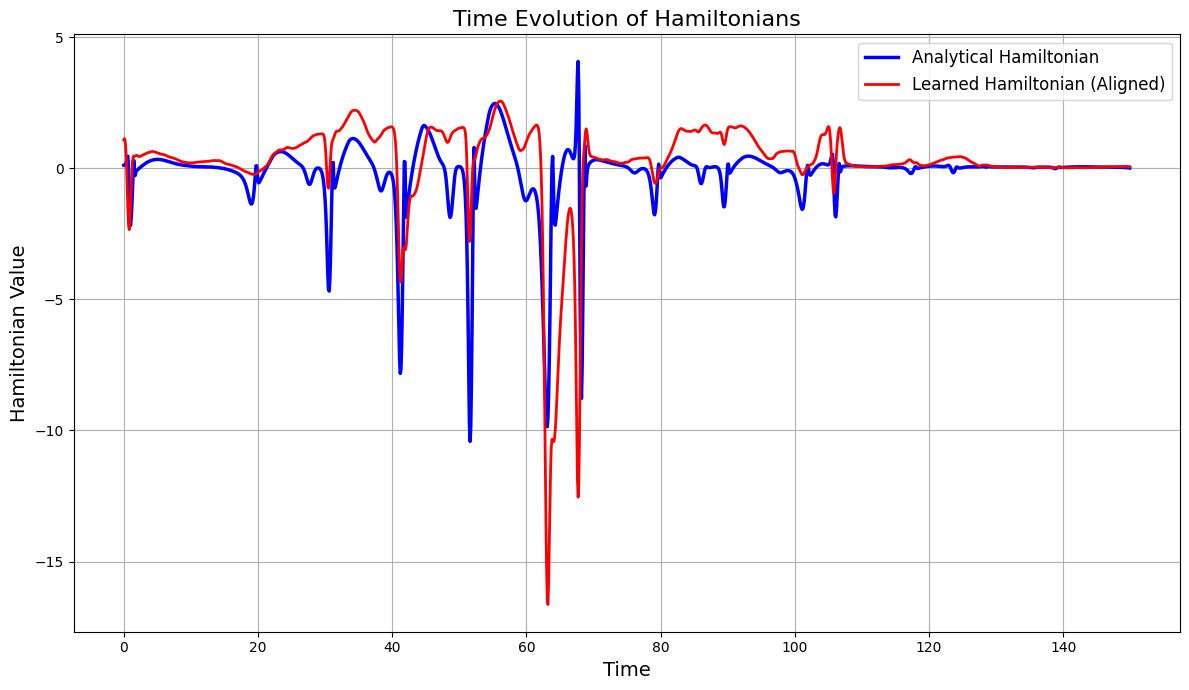

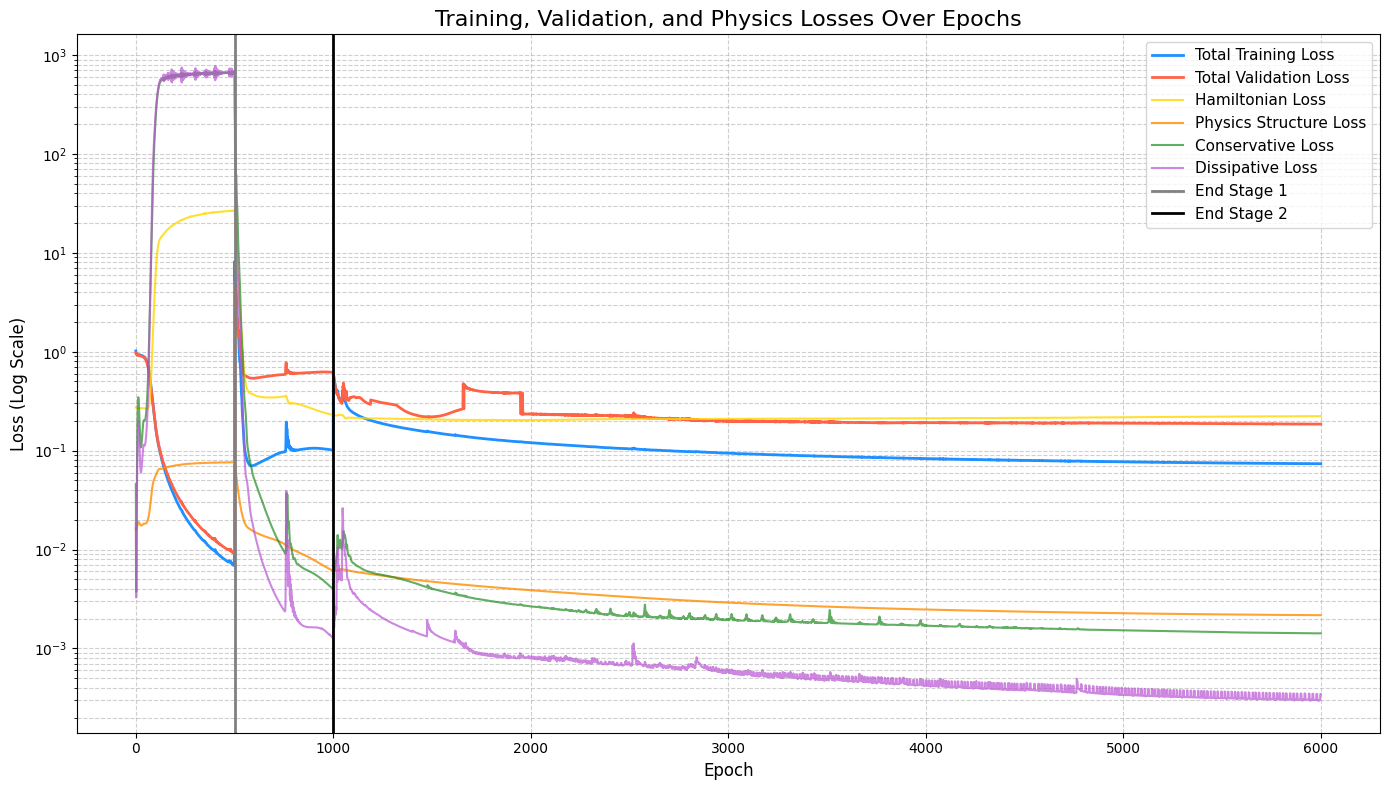

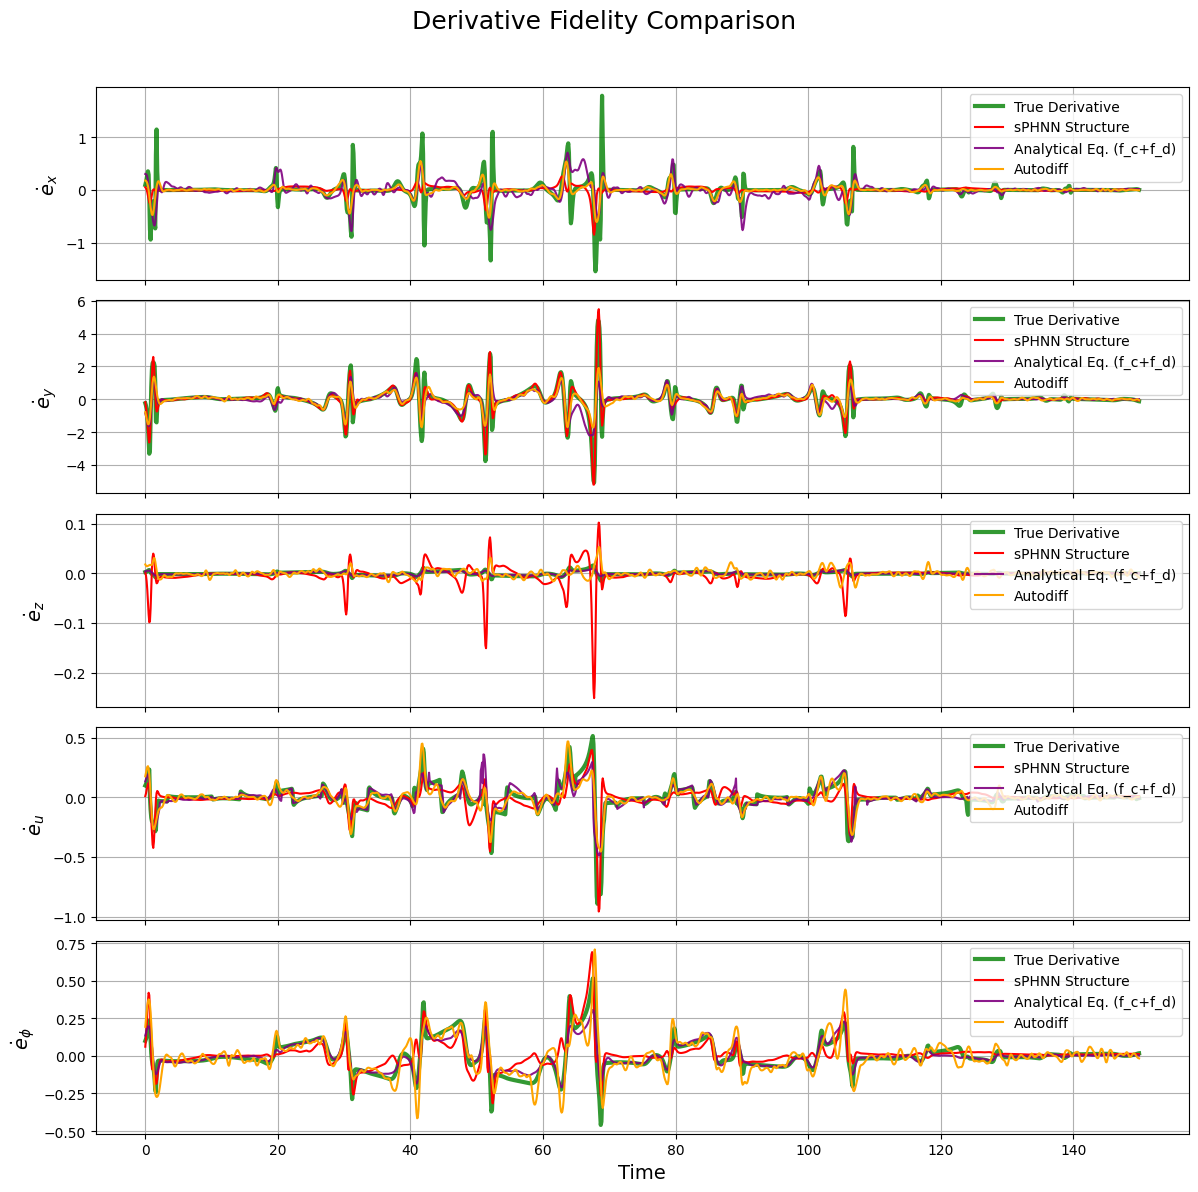

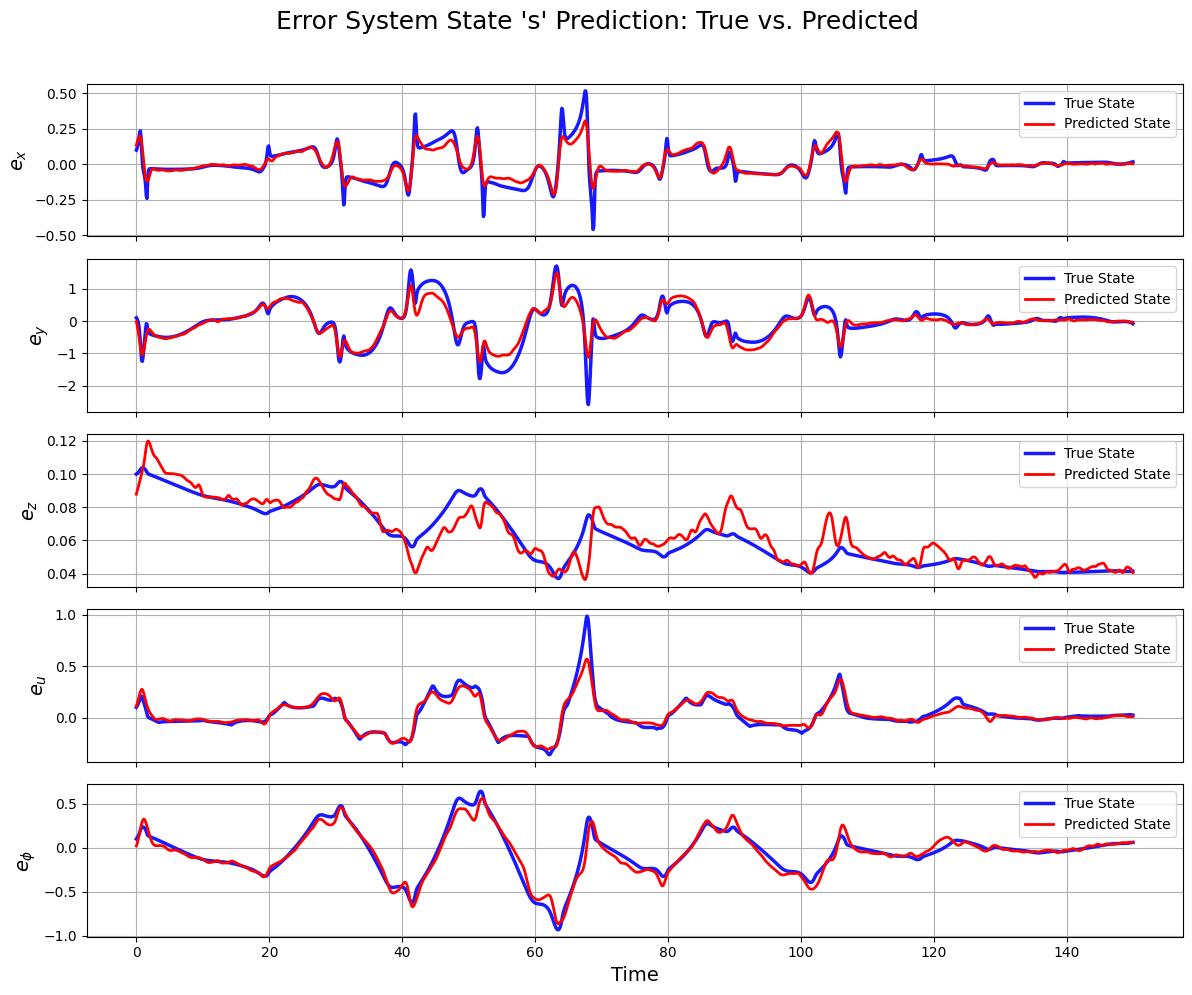

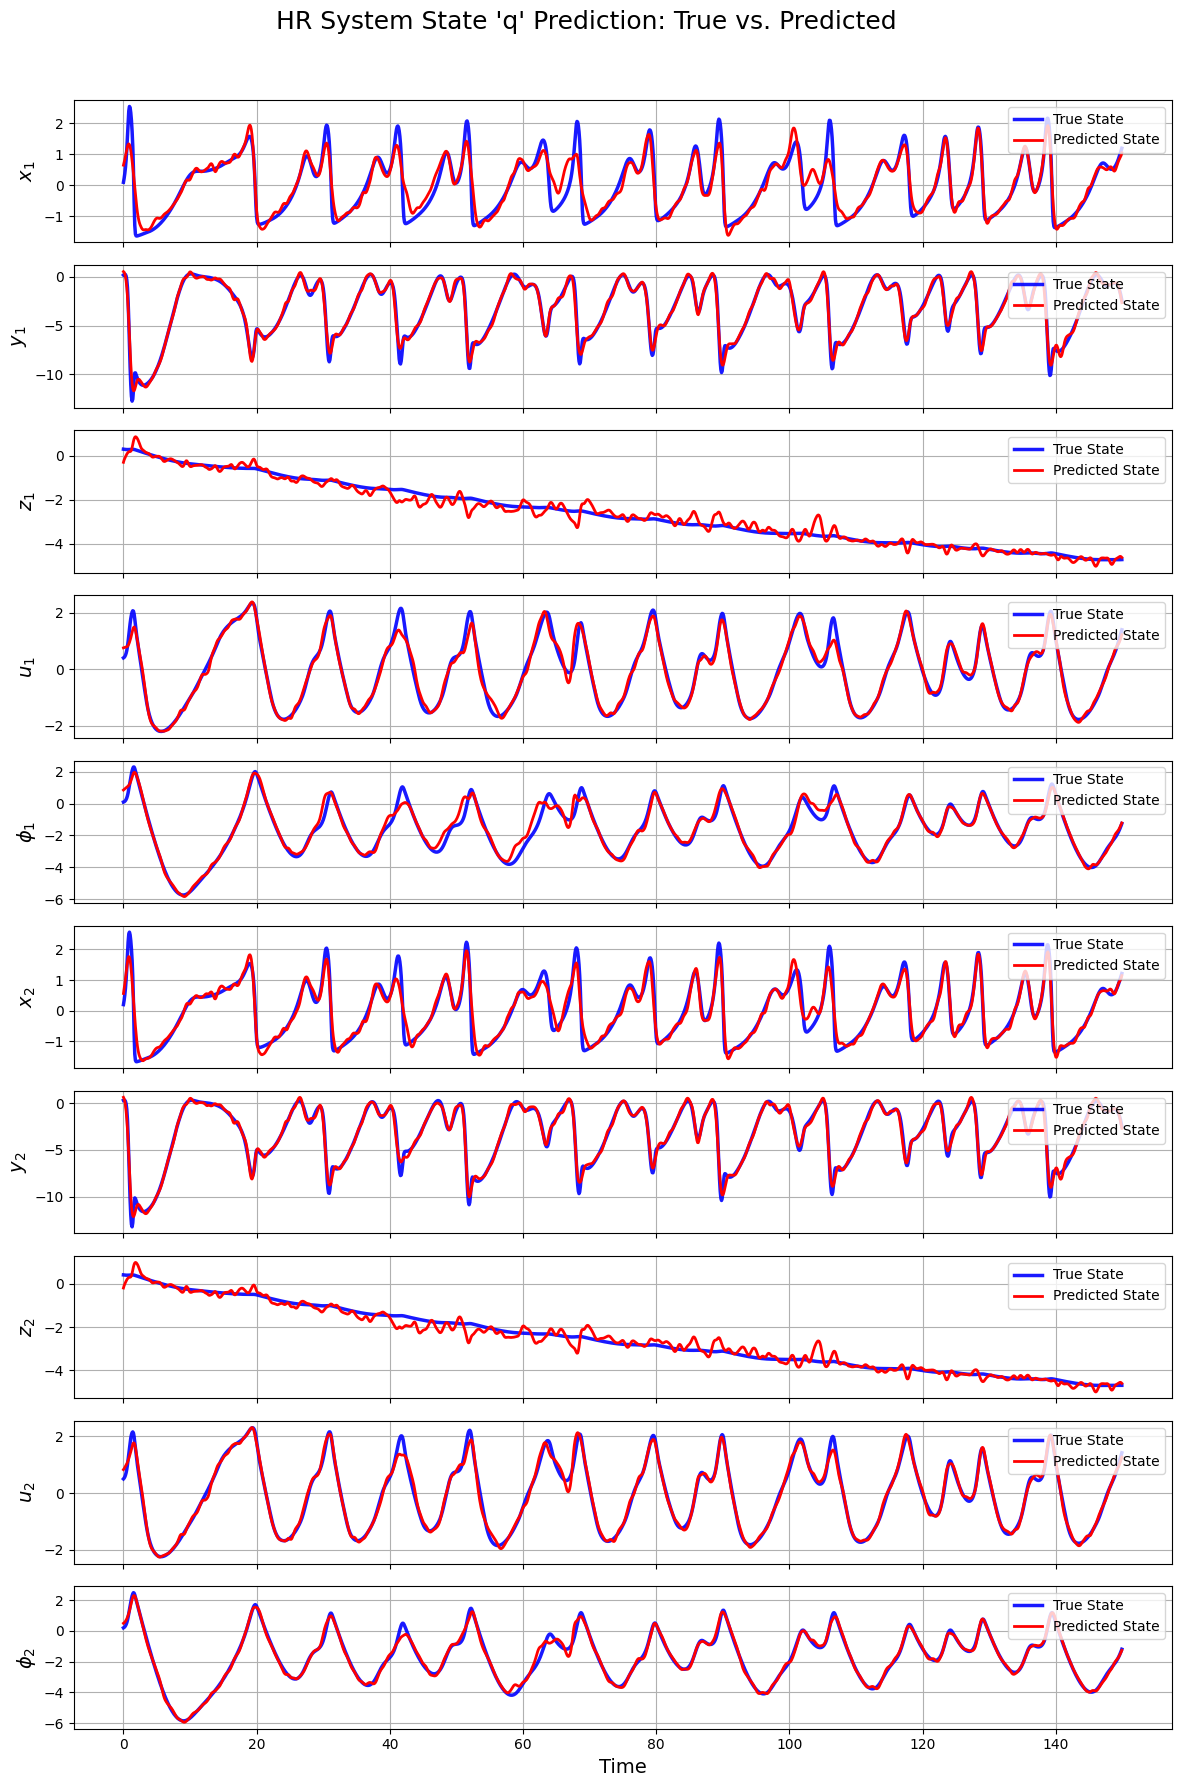

All visualization plots have been generated and saved.


In [7]:
# ==============================================================================
# 5. VISUALIZATION AND ANALYSIS
# ==============================================================================

print("\nGenerating visualization plots...")
# Use the full, unsplit, time-ordered data for coherent plots
t_test = t.reshape(-1, 1)
s_test, q_test, s_dot_test, H_analytical_vis = s, q, s_dot_true, H_analytical
t_test_norm = normalize(t_test, t_mean, t_std)

# --- Get all model predictions for the full dataset ---
all_states_pred_norm = jax.vmap(best_model.state_net)(t_test_norm)
q_pred_norm = all_states_pred_norm[:, :10]
s_pred_norm = all_states_pred_norm[:, 10:]

s_pred = denormalize(s_pred_norm, s_mean, s_std)
q_pred = denormalize(q_pred_norm, q_mean, q_std)

# --- Calculate all derivatives for comparison ---
grad_H_norm = jax.vmap(jax.grad(best_model.hamiltonian_net))(s_pred_norm)
J_norm = jax.vmap(best_model.j_net)(s_pred_norm)
R_norm = jax.vmap(best_model.dissipation_net)(s_pred_norm)
s_dot_from_structure_norm = jax.vmap(lambda j, r, g: (j - r) @ g)(J_norm, R_norm, grad_H_norm)
s_dot_from_structure = s_dot_from_structure_norm * s_std

f_c_batch_vis = jax.vmap(f_c_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
f_d_batch_vis = jax.vmap(f_d_fn, in_axes=(0, 0, None))(s_pred, q_pred, hr_params)
s_dot_from_equations = f_c_batch_vis + f_d_batch_vis

# Need to compute autodiff for the s-slice of the StateNN's output
get_s_slice_autodiff_grad = lambda net, t: jax.jvp(lambda t_scalar: net(t_scalar)[10:], (t,), (jnp.ones_like(t),))[1]
s_dot_autodiff_norm = jax.vmap(get_s_slice_autodiff_grad, in_axes=(None, 0))(best_model.state_net, t_test_norm)
s_dot_autodiff = s_dot_autodiff_norm * (s_std / (t_std + 1e-8))


# --- Plot 1: Learned vs Analytical Hamiltonian ---
print("Comparing learned Hamiltonian with analytical solution...")
H_learned_norm = jax.vmap(best_model.hamiltonian_net)(s_pred_norm)
# The learned Hamiltonian might be flipped in sign, so we check correlation and align it.
correlation = jnp.corrcoef(H_analytical_vis.flatten(), H_learned_norm.flatten())[0, 1]
sign = jnp.sign(correlation)
H_learned_signed = sign * H_learned_norm
H_learned_aligned = H_learned_signed - jnp.mean(H_learned_signed) + jnp.mean(H_analytical_vis)


plt.figure(figsize=(12, 7))
plt.plot(t_test[:1500], H_analytical_vis[:1500], label='Analytical Hamiltonian', color='blue', linewidth=2.5)
plt.plot(t_test[:1500], H_learned_aligned[:1500], label='Learned Hamiltonian (Aligned)', color='red', linewidth=2)
plt.title("Time Evolution of Hamiltonians", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Hamiltonian Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("hamiltonian_comparison.png", dpi=300)


# --- Plot 2: Training, Validation, and Physics Losses ---
# Extract individual loss components for plotting
phys_losses = [d['phys'] for d in all_loss_components]
conservative_losses = [d['conservative'] for d in all_loss_components]
dissipative_losses = [d['dissipative'] for d in all_loss_components]
hamiltonian_losses = [d['hamiltonian'] for d in all_loss_components]

plt.figure(figsize=(14, 8))
plt.plot(train_losses, label='Total Training Loss', color='dodgerblue', linewidth=2)
plt.plot(val_losses, label='Total Validation Loss', color='tomato', linewidth=2)
plt.plot(hamiltonian_losses, label='Hamiltonian Loss', color='gold', alpha=0.8)
plt.plot(phys_losses, label='Physics Structure Loss', color='darkorange', alpha=0.8)
plt.plot(conservative_losses, label='Conservative Loss', color='forestgreen', alpha=0.7)
plt.plot(dissipative_losses, label='Dissipative Loss', color='mediumorchid', alpha=0.7)

# Add vertical lines to mark stage transitions
stage1_end = epochs_stage1
stage2_end = epochs_stage1 + epochs_stage2
plt.axvline(x=stage1_end, color='grey', linewidth=2, label='End Stage 1')
plt.axvline(x=stage2_end, color='black', linewidth=2, label='End Stage 2')

plt.yscale('log')
plt.title('Training, Validation, and Physics Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Log Scale)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.savefig("loss_curves_combined.png", dpi=300)

# --- Plot 3: Derivative Comparison (Physics Fidelity) ---
fig, axes = plt.subplots(s_test.shape[1], 1, figsize=(12, 12), sharex=True)
state_labels_s_dot = [r'$\dot{e}_x$', r'$\dot{e}_y$', r'$\dot{e}_z$', r'$\dot{e}_u$', r'$\dot{e}_\phi$']
fig.suptitle("Derivative Fidelity Comparison", fontsize=18, y=0.99)

for i in range(s_test.shape[1]):
    axes[i].plot(t_test[:1500], s_dot_test[:1500, i], label='True Derivative', color='green', linewidth=3, alpha=0.8)
    axes[i].plot(t_test[:1500], s_dot_from_structure[:1500, i], label='sPHNN Structure', color='red')
    axes[i].plot(t_test[:1500], s_dot_from_equations[:1500, i], label='Analytical Eq. (f_c+f_d)', color='purple', alpha=0.9)
    axes[i].plot(t_test[:1500], s_dot_autodiff[:1500, i], label='Autodiff', color='orange')

    axes[i].set_ylabel(state_labels_s_dot[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Plot 4: Error System State Trajectories (s) ---
fig, axes = plt.subplots(s_test.shape[1], 1, figsize=(12, 10), sharex=True)
state_labels_error = [r'$e_x$', r'$e_y$', r'$e_z$', r'$e_u$', r'$e_\phi$']
fig.suptitle("Error System State 's' Prediction: True vs. Predicted", fontsize=18, y=0.99)
for i in range(s_test.shape[1]):
    axes[i].plot(t_test[:1500], s_test[:1500, i], 'b', label='True State', alpha=0.9, linewidth=2.5)
    axes[i].plot(t_test[:1500], s_pred[:1500, i], 'r', label='Predicted State', linewidth=2)
    axes[i].set_ylabel(state_labels_error[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Plot 5: HR System State Trajectories (q) ---
fig, axes = plt.subplots(q_test.shape[1], 1, figsize=(12, 18), sharex=True)
state_labels_q = [
    r'$x_1$', r'$y_1$', r'$z_1$', r'$u_1$', r'$\phi_1$',
    r'$x_2$', r'$y_2$', r'$z_2$', r'$u_2$', r'$\phi_2$'
]
fig.suptitle("HR System State 'q' Prediction: True vs. Predicted", fontsize=18, y=0.99)
for i in range(q_test.shape[1]):
    axes[i].plot(t_test[:1500], q_test[:1500, i], 'b', label='True State', alpha=0.9, linewidth=2.5)
    axes[i].plot(t_test[:1500], q_pred[:1500, i], 'r', label='Predicted State', linewidth=2)
    axes[i].set_ylabel(state_labels_q[i], fontsize=14)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

print("All visualization plots have been generated and saved.")
